## Item-Based Collaborative Filtering
    - Implement item-based collaborative filtering algorithm with MovieLens dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, evaluate
from surprise import KNNBasic, KNNBaseline
from surprise import Reader
from surprise import accuracy


In [2]:
ratings = pd.read_csv("ratings.csv", usecols = ['userId', 'movieId', 'rating'])

reader = Reader(rating_scale=(1, 5))
#ratings_small = ratings.sample(frac = 0.1)


#ratings_training = ratings_small.sample(frac=0.7)
#ratings_test = ratings_small.drop(ratings_training.index)

#split the data into training and test set (70-30)
ratings_training = ratings.sample(frac=0.7, random_state = 4571)
ratings_test = ratings.drop(ratings_training.index)

training = Dataset.load_from_df(ratings_training,reader)
test = Dataset.load_from_df(ratings_test, reader)                                   
                                   
ratings_training = training.build_full_trainset()                                   

## Neighborhood-based Collaborative Filtering
    - build item-based CF algorithm
    - apply different similarity metrics
        * Pearson Baseline
        * Pearson Correlation
        * Cosine Similarity
    - evaluation 
        * cross-validation
        * accuracy on training and test set data
            a. RMSE
            b. MAE
        * coverage
            a. catalog-coverage
            b. user-coverage
            c. item-coverage

In [3]:
from math import sqrt
def compute_RMSE(pred, original):
    n = len(pred)
    RMSE = sqrt(sum((pred-original)**2)/n)
    return RMSE

In [4]:
def compute_MAE(pred, original):
    n = len(pred)
    MAE = sum(abs(original - pred))/n
    return MAE

In [5]:
#try three different similarity metrics
sim_options_pb = {'name': 'pearson_baseline', 'user_based': False}
sim_options_p = {'name': 'pearson', 'user_based': False}
sim_options_cos = {'name': 'cosine', 'user_based': False}

#create a list of max-k
num_k = [5, 10, 20, 30, 40]

#initialize lists for RMSE and MAE
RMSE_pb = []
RMSE_p = []
RMSE_cos = []

MAE_pb = []
MAE_p = []
MAE_cos = []

for k in num_k:
    #train three models
    knn_pb = KNNBasic(sim_options = sim_options_pb, k = k)
    knn_p = KNNBasic(sim_options = sim_options_p, k = k)
    knn_cos = KNNBasic(sim_options = sim_options_cos, k = k)
    knn_pb.fit(ratings_training)
    knn_p.fit(ratings_training)
    knn_cos.fit(ratings_training)
    
    #prediction for test set
    ratings_test['predRatings_Pearson_baseline'] = ""
    ratings_test['predRatings_Pearson'] = ""
    ratings_test['predRatings_Cosine'] = ""
    
    for i in range(len(ratings_test)):
        uid = ratings_test.iloc[i,0]
        iid = ratings_test.iloc[i,1]
        rui = ratings_test.iloc[i,2]
        #pred = knn.predict(uid, iid, r_ui = 4, verbose = True)
        pred_pb = knn_pb.predict(uid, iid, r_ui = rui)
        pred_p = knn_p.predict(uid, iid, r_ui = rui)
        pred_cos = knn_cos.predict(uid, iid, r_ui = rui)
        #print(pred.est)
        ratings_test.iloc[i,3] = round(pred_pb.est,1)
        ratings_test.iloc[i,4] = round(pred_p.est,1)
        ratings_test.iloc[i,5] = round(pred_cos.est,1)
    
    #calculate RMSE
    rmse_pb = compute_RMSE(ratings_test.iloc[:,2], ratings_test.iloc[:,3])
    rmse_p = compute_RMSE(ratings_test.iloc[:,2], ratings_test.iloc[:,4])
    rmse_cos = compute_RMSE(ratings_test.iloc[:,2], ratings_test.iloc[:,5])
    
    RMSE_pb.append(round(rmse_pb,4))
    RMSE_p.append(round(rmse_p,4))
    RMSE_cos.append(round(rmse_cos,4))
    
     #calculate MAE
    mae_pb = compute_MAE(ratings_test.iloc[:,2], ratings_test.iloc[:,3])
    mae_p = compute_MAE(ratings_test.iloc[:,2], ratings_test.iloc[:,4])
    mae_cos = compute_MAE(ratings_test.iloc[:,2], ratings_test.iloc[:,5])
    
    MAE_pb.append(round(mae_pb,4))
    MAE_p.append(round(mae_p,4))
    MAE_cos.append(round(mae_cos,4))
    

print('RMSE of Pearson Baseline: ', RMSE_pb)
print('RMSE of Pearson:', RMSE_p)
print('RMSE of cosine:', RMSE_cos)


print('MAE of Pearson Baseline: ', MAE_pb)
print('MAE of Pearson:', MAE_p)
print('MAE of cosine:', MAE_cos)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

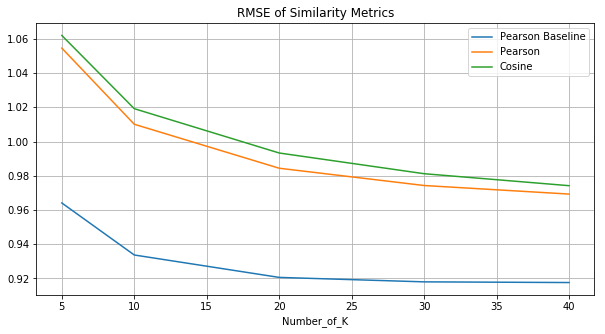

In [6]:
#plot RMSE and MAE for three similarity metrics

RMSE = pd.DataFrame(
    {'Number_of_K': num_k,
     'Pearson Baseline': RMSE_pb,
     'Pearson': RMSE_p,
     'Cosine': RMSE_cos   
    })
fig = RMSE.plot(x = 'Number_of_K', y = ['Pearson Baseline', 'Pearson', 'Cosine'],figsize = (10,5), grid = True, title = "RMSE of Similarity Metrics")

plt.show()

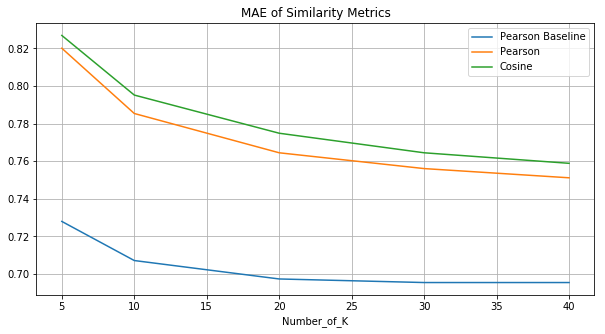

In [7]:
MAE = pd.DataFrame(
    {'Number_of_K': num_k,
     'Pearson Baseline': MAE_pb,
     'Pearson': MAE_p,
     'Cosine': MAE_cos   
    })
fig = MAE.plot(x = 'Number_of_K', y = ['Pearson Baseline', 'Pearson', 'Cosine'],figsize = (10,5), grid = True, title = "MAE of Similarity Metrics")
#fig.ylabel('RMSE')
#fig.xlabel('Number of K')
plt.show()

Pearson Baseline provides the lowest RMSE and MAE.

## Cross-validation 

    - Use cross-validation to get a mean error on the training set.
    

In [10]:
def k_fold_cv(train, k):
    """
    input: 
        train - dataframe of training set
        k - number of folds we choose for cross-validation
        
    output:
        mean_error - mean error genereated by cross-validation
    """
    # scikit-learn k-fold cross-validation
    from sklearn.model_selection import KFold
    kfold = KFold(k, True, 4571)
    sim_options_pb = {'name': 'pearson_baseline', 'user_based': False}
    reader = Reader(rating_scale=(1, 5))
    cv_rmse = []
    # enumerate splits
    for training, test in kfold.split(train):
        training = list(training)
        training = train.iloc[training, :]
        test = train.iloc[test, :]

        training = Dataset.load_from_df(training,reader)
        #test = Dataset.load_from_df(test, reader)  
        
        training = training.build_full_trainset()
        
        knn_pb = KNNBasic(sim_options = sim_options_pb)
        knn_pb.fit(training)
        #prediction for test set
        test['pred'] = ""
        
        for i in range(len(test)):
            uid = test.iloc[i,0]
            iid = test.iloc[i,1]
            rui = test.iloc[i,2]
            pred_pb = knn_pb.predict(uid, iid, r_ui = rui)
            test.iloc[i,3] = round(pred_pb.est,1)

        #calculate RMSE
        rmse_pb = compute_RMSE(test.iloc[:,2], test.iloc[:,3])
        cv_rmse.append(round(rmse_pb,4))
        
    #calculate the mean error
    mean_error = sum(cv_rmse)/len(cv_rmse)
    return round(mean_error, 4)



In [11]:
#calculate training error using cross-validation
ratings_training = ratings.sample(frac=0.7, random_state = 4571)
mean_error = k_fold_cv(ratings_training, 3)
print("Mean error of cross-validation is: ", round(mean_error, 4))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Mean error of cross-validation is:  0.9622


### Coverage on training and test data
    
    In this case, we define an item is well-recommended if the recommended item has a rating greater than or equal to 4.5 given by this user in the test set.
    
    - item coverage:
        n = number of well-recommended items included in the recommedation list
        N = total number of potential items
        
        C_item = n/N * 100
        
    - User coverage:
        u = number of users for whom the recommender system was able to recommended at least k items well. 
        U = total number of potential users
        
        C_user = u/U * 100
        
    - Catalog coverage:
        T = number of items that are in the top-k for at least 1 user
        N = total number of potential items
        
        C_interaction = T/N * 100

In [12]:
from collections import defaultdict

def get_topN_recommendations(predictions, topN = 3):
    """
    Input: predictions: predict results from KNNBasic.test()
           topN: number of recommendations requested
           
    Output: top_recs: dictionary of top N recommendations for each user
    """
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
        
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
        
    return top_recs

In [13]:
ratings_training = training.build_full_trainset()   
knn_pb = KNNBasic(sim_options = sim_options_pb)
knn_pb.fit(ratings_training)

testset = ratings_training.build_anti_testset()


train_knn = knn_pb.test(ratings_training.build_testset())
test_knn = knn_pb.test(testset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [14]:
testset = test.build_full_trainset()   
test_knn = knn_pb.test(testset.build_testset())

In [15]:
#get the number of items in training and test

def get_inumber(predictions):
    '''Return the the number of items from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
    
    Returns:
    An integer presenting the number of items
    '''
    
    #create a list to store items
    total_items = []
    for uid, iid, true_r, est, _ in predictions:
        if iid not in total_items:
            total_items.append(iid)
    
    #return the length of list
    num_items = len(total_items)
    
    return num_items

#in_train_knn = get_inumber(train_knn)
#in_test_knn = get_inumber(test_knn)
#print("Number of items in training set:", in_train_knn)
#print("Number of items in test set:", in_test_knn)



#get the number of users in training and test
def get_unumber(predictions):
    '''Return the the number of users from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
    
    Returns:
    An integer presenting the number of users
    '''
    
    #create a list to store users
    total_users = []
    for uid, iid, true_r, est, _ in predictions:
        if uid not in total_users:
            total_users.append(uid)
    
    #return the length of list
    num_users = len(total_users)
    
    return num_users

#un_train_knn = get_unumber(train_knn)
#un_test_knn = get_unumber(test_knn)
#print("Number of users in training set:", un_train_knn)
#print("Number of users in test set:",un_test_knn)

In [16]:
#catalog-coverage for training set and test set

def catalog_coverage(trainset, testset, n):
    """
    Input: 
        trainset, testset - datasets predicted by a recommender system model, either training or test set
        n - number of top n recommendations
    
    Output: 
        cat_train, cat_test - catalog coverage for training and test set
    
    """
    top_n_train =  get_topN_recommendations(trainset, n)
    in_train = get_inumber(trainset)
    #create a list to store the items recommended
    cata_cov= []
    for i in range(1, len(top_n_train) + 1):
        for item in top_n_train[i]:
            if item[0] not in cata_cov:
                cata_cov.append(item[0])

    cat_train = round(len(cata_cov) / in_train, 4)
    print("Catalog-coverage for train:", cat_train)
    
    top_n_test =  get_topN_recommendations(testset, n)
    in_test = get_inumber(testset)
    #create a list to store the items recommended
    cata_cov= []
    for i in range(1, len(top_n_test) + 1):
        for item in top_n_test[i]:
            if item[0] not in cata_cov:
                cata_cov.append(item[0])

    cat_test = round(len(cata_cov) / in_test, 4)
    print("Catalog-coverage for test:", cat_test)
    
    return cat_train, cat_test

In [17]:
catalog_coverage(train_knn, test_knn, 5)

Catalog-coverage for train: 0.2012
Catalog-coverage for test: 0.227


(0.2012, 0.227)

In [18]:
#user-coverage for training set and test set
def user_cov(trainset, testset, n = 10,  k = 5):
    '''Return the the number of users for which at least k items' ratings reach 4.5 from a recommendation dict.

    Args:
        top_n (A dict where keys are user (raw) ids and values are lists of tuples):
        [(raw item id, rating estimation), ...] of size n.
        k (int): Default is 5.
    
    Returns:
        count_train, count_test: An integer presenting the number of users
    '''
    
    top_n_train= get_topN_recommendations(trainset, n)
    #create a dict to store the users' recommended items whose ratings reach 4.5
    #count = count + 1 if the i-th user has more than k recommended well items
    user_cover = defaultdict(list)
    count_train = 0
    for i in range(len(top_n_train)):
        for item in top_n_train[i]:
            if item[1] >= 4.5:
                user_cover[i].append(item)
        if len(user_cover[i]) >= k:
            count_train += 1
            
    top_n_test= get_topN_recommendations(testset, n)
    #create a dict to store the users' recommended items whose ratings reach 4.5
    #count = count + 1 if the i-th user has more than k recommended well items
    user_cover = defaultdict(list)
    count_test = 0
    for i in range(len(top_n_test)):
        for item in top_n_test[i]:
            if item[1] >= 4.5:
                user_cover[i].append(item)
        if len(user_cover[i]) >= k:
            count_test += 1
    
    #calculate number of users for training and test sets
    un_train = get_unumber(trainset)
    un_test = get_unumber(testset)
    
    user_train = round(count_train/un_train, 4)
    user_test = round(count_test/un_test, 4)
    
    print("User-coverage for training:", user_train)
    print("User-coverage for test:", user_test)
    
    return user_train, user_test


In [19]:
user_cov(train_knn, test_knn, 5, 5)

User-coverage for training: 0.5918
User-coverage for test: 0.0852


(0.5918, 0.0852)

In [20]:
#item-coverage for training set and test set
def item_cov(trainset, testset, n = 10, k = 1):
    '''Return the the number of items at least recommended to k users 
       whose ratings reach 4.5 from a recommendation dict.

    Args:
        top_n (A dict where keys are user (raw) ids and values are lists of tuples):
        [(raw item id, rating estimation), ...] of size n.
        n (int): the total number of items of the dataset.
        k (int): Default is 5.
    
    Returns:
    An integar presenting the number of users
    '''
    
    #calculate top n recommendations and number of items for training and test sets
    top_n_train= get_topN_recommendations(trainset, n)
    in_train = get_inumber(trainset)
    #create a dict to store the items whose ratings reach 4.5 and the users they're recommended to
    item_cover = defaultdict(list)
    count_train = 0
    for i in range(len(top_n_train)):
        for item in top_n_train[i]:
            if item[1] >= 4.5:
                item_cover[item[0]].append(item)
                
    #count = count + 1 if the i-th item has more than k users
    for i in range(in_train):
        if len(item_cover[i]) >= k:
            count_train += 1
            
    top_n_test= get_topN_recommendations(testset, n)
    in_test = get_inumber(testset)
    #create a dict to store the items whose ratings reach 4.5 and the users they're recommended to
    item_cover = defaultdict(list)
    count_test = 0
    for i in range(len(top_n_test)):
        for item in top_n_test[i]:
            if item[1] >= 4.5:
                item_cover[item[0]].append(item)
                
    #count = count + 1 if the i-th item has more than k users
    for i in range(in_test):
        if len(item_cover[i]) >= k:
            count_test += 1            
    item_train = round(count_train/in_train, 4)
    item_test = round(count_test/in_test, 4)
    
    print("Item-coverage of training set:", item_train)
    print("Item-coverage of test set:", item_test)
    
    return item_train, item_test


In [21]:
item_cov(train_knn, test_knn, 5)

Item-coverage of training set: 0.1169
Item-coverage of test set: 0.0476


(0.1169, 0.0476)

## Tune the Parameter

    As we are using item-based collaberative filtering model, our hyper parameter is the number of nearest neighborhood (k). We will tune the parameter and explore the relationships between k and accuracy/coverage.

In [ ]:
#create a list of k
num_k = range(5, 40, 5)
#RMSE_train = []
RMSE_test = []
#MAE_train = []
MAE_test = []
c_cov_train = []
c_cov_test = []
u_cov_train = []
u_cov_test = []
i_cov_train = []
i_cov_test = []

ratings_training = ratings.sample(frac=0.7, random_state = 4571)
ratings_test = ratings.drop(ratings_training.index)

print("Compare different number of nearest neighbors")
for k in num_k:
    #train the model

    ratings_training = training.build_full_trainset()   
    knn_pb = KNNBasic(sim_options = sim_options_pb, k = k)
    knn_pb.fit(ratings_training)

    testset = ratings_training.build_anti_testset()


    #calculate the rmse and mae of training and test
    train_knn = knn_pb.test(ratings_training.build_testset())
    test_knn = knn_pb.test(testset)
    
    ratings_test['predRatings_Pearson_baseline'] = ""

    for i in range(len(ratings_test)):
        uid = ratings_test.iloc[i,0]
        iid = ratings_test.iloc[i,1]
        #pred = knn.predict(uid, iid, r_ui = 4, verbose = True)
        rui = ratings_test.iloc[i,2]
        pred_pb = knn_pb.predict(uid, iid, r_ui = rui, verbose = False)
        #print(pred.est)
        ratings_test.iloc[i,3] = round(pred_pb.est,1)

    #calculate RMSE
    rmse_pb = compute_RMSE(ratings_test.iloc[:,2], ratings_test.iloc[:,3])
    RMSE_test.append(round(rmse_pb,4))
    
    #calculate MAE
    mae_pb = compute_MAE(ratings_test.iloc[:,2], ratings_test.iloc[:,3])
    MAE_test.append(round(mae_pb,4))
    
    
    #catalog-coverage for training set and test set
    cat_train, cat_test = catalog_coverage(train_knn, test_knn, 10)
    
    c_cov_train.append(cat_train)
    c_cov_test.append(cat_test)
   
    #user-coverage for training and test set
    user_train, user_test = user_cov(train_knn, test_knn, 10)
    
    
    u_cov_train.append(user_train)
    u_cov_test.append(user_test)
    
    #item-coverage for training and test set
    item_train, item_test = item_cov(train_knn, test_knn, 10)
    
    i_cov_train.append(item_train)
    i_cov_test.append(item_test)

In [23]:
Tune_K = pd.DataFrame(
    {'Number_of_K': num_k,
     'RMSE_test': RMSE_test,
     'MAE_test': MAE_test,
     'Catalog_Coverage_train': c_cov_train,
     'Catalog_Coverage_test': c_cov_test,
     'User_Coverage_train': u_cov_train,
     'User_Coverage_test': u_cov_test,
     'Item_Coverage_train': i_cov_train,
     'Item_Coverage_test': i_cov_test
    })

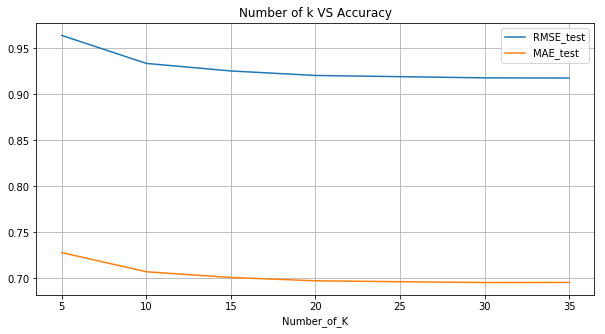

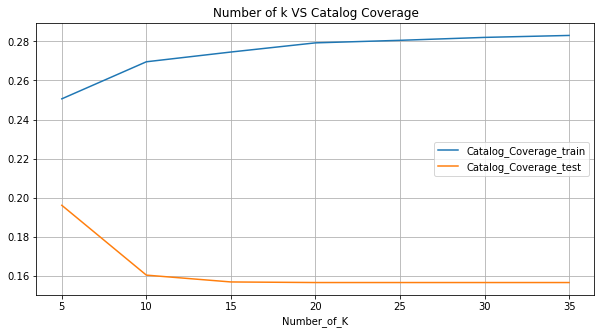

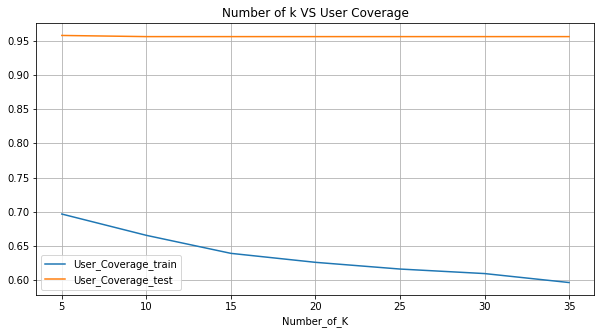

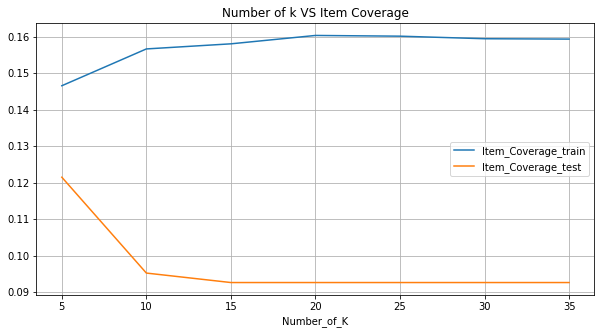

In [24]:
fig = Tune_K.plot(x = 'Number_of_K', y = ['RMSE_test', 'MAE_test'],figsize = (10,5), grid = True, title = "Number of k VS Accuracy")
plt.show()
fig = Tune_K.plot(x = 'Number_of_K', y = ['Catalog_Coverage_train', 'Catalog_Coverage_test'],figsize = (10,5), grid = True, title = "Number of k VS Catalog Coverage")
plt.show()
fig = Tune_K.plot(x = 'Number_of_K', y = ['User_Coverage_train', 'User_Coverage_test'],figsize = (10,5), grid = True, title = "Number of k VS User Coverage")
plt.show()
fig = Tune_K.plot(x = 'Number_of_K', y = ['Item_Coverage_train', 'Item_Coverage_test'],figsize = (10,5), grid = True, title = "Number of k VS Item Coverage")
plt.show()

### Results

     - Test Error: As the number of nearest neighbor increases, there is a decrease in both the RMSE and MAE for test set. 

     - Catalog Coverage: Although the larger number of nearest neighbor results in an increase of catalog coverage for the training set, the catalog coverage for test set actually decreases by a relatively small amount.

     - User Coverage: User coverage for training set decreases with the increase of the number of nearest neighbor.

     - Item Coverage: Although the larger number of nearest neighbor results in an increase of item coverage for the training set, the item coverage for test set actually decreases by a relatively small amount.

## Explore the relationship between model size and accuracy/run-time
    - Try different subsets of the whole dataset
    - Calculate accuracy and run-time for each subset
    - Compare by the size of each subset

In [25]:
import numpy as np
import time
ratings = pd.read_csv("ratings.csv", usecols = ['userId', 'movieId', 'rating'])

RMSE_sub = []
exe_time_sub = []

sub = np.arange(0.1, 1.1, 0.1)
for prop in sub:
    start_time = time.time()
    ratings_sub = ratings.sample(frac = prop, random_state = 4571)
    reader = Reader(rating_scale=(1, 5))
    ratings_training = ratings_sub.sample(frac=0.7, random_state = 4571)
    ratings_test = ratings_sub.drop(ratings_training.index)

    training = Dataset.load_from_df(ratings_training,reader)
    test = Dataset.load_from_df(ratings_test, reader)                                   

    ratings_training = training.build_full_trainset()
    sim_options_pb = {'name': 'pearson_baseline', 'user_based': False}

    knn_pb = KNNBasic(sim_options = sim_options_pb)
    knn_pb.fit(ratings_training)
    
    #prediction for test set
    ratings_test['predRatings_Pearson_baseline'] = ""

    for i in range(len(ratings_test)):
        uid = ratings_test.iloc[i,0]
        iid = ratings_test.iloc[i,1]
        #pred = knn.predict(uid, iid, r_ui = 4, verbose = True)
        rui = ratings_test.iloc[i,2]
        pred_pb = knn_pb.predict(uid, iid, r_ui = rui, verbose = False)
        #print(pred.est)
        ratings_test.iloc[i,3] = round(pred_pb.est,1)

    #calculate RMSE
    rmse_pb = compute_RMSE(ratings_test.iloc[:,2], ratings_test.iloc[:,3])
    RMSE_sub.append(round(rmse_pb,4))

    #record execution time
    exe_time = time.time() - start_time
    exe_time_sub.append(round(exe_time, 4))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

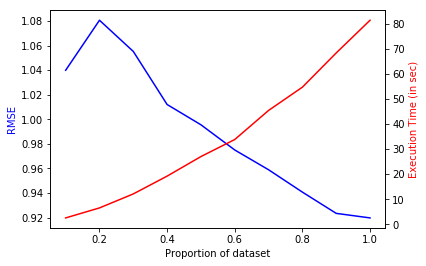

In [26]:
RMSE_TIME = pd.DataFrame(
    {'Proportion of dataset': sub,
     'RMSE': RMSE_sub,
     'Execution Time': exe_time_sub
    })
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(RMSE_TIME['Proportion of dataset'], RMSE_TIME['RMSE'], 'b-')
ax2.plot(RMSE_TIME['Proportion of dataset'], RMSE_TIME['Execution Time'], 'r-')

ax1.set_xlabel('Proportion of dataset')
ax1.set_ylabel('RMSE', color = 'b')
ax2.set_ylabel('Execution Time (in sec)', color = 'r')


plt.show()

### Results

    Both the overall accuracy and the execution time goes up (RMSE goes down) when the sample size is increasing, which meets our expectation.

## Conclusion

 In this project we implemented item-based CF algorithm and applied it to the MovieLens dataset, which yields to an optimal RMSE of 0.92 when the number of nearest neighbors is 35. The test error and the user coverage are optimized with an increase of the number of nearest neighbors considered when building the model. However, if we compare the result with what matrix factorization achieves, we would find that MF provides a more accurate and more efficient solution of this problem.